# Yelp Review Prediction
Objective: Construct and train a Neural Network that would be able to predict the number of star ratings from a Yelp review.    
Dataset used: https://www.yelp.com/dataset/challenge  

Steps:  
1) Data Preprocessing  
2) Deep Learning Preprocessing  
3) Network Training  
4) Network Testing  

In [28]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline
from langdetect import detect
import time
import numpy as np
import pandas as pd
from pandas_ml import ConfusionMatrix
import seaborn

import sklearn as sk
from sklearn.model_selection import train_test_split
import numpy as np
import json

import tensorflow as tf
from tensorflow.python.layers.core import Dense
from tensorflow.python.ops.rnn_cell_impl import _zero_state_tensors
import pickle

import matplotlib.pyplot as plt
import random
import nltk, re, time
from nltk.corpus import stopwords
import string
from collections import defaultdict
from collections import namedtuple
from contractions import get_contractions

import operator
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import tensor_array_ops
print('TensorFlow Version: {}'.format(tf.__version__))

alreadyPickled = False

TensorFlow Version: 1.5.0


## Variable Initialization

In [2]:
embedding_dim = 300
num_layers = 2
num_classes = 6
epochs = 5
batch_size = 64
rnn_size = 64
num_layers = 2

learning_rate = 0.005

keep_probability = 0.8
max_sequence_length = 750

IS_TRAINING = True
IS_TESTING = False

# Data Loading
If the data is already pickled, then can skip embedding and data processing

In [19]:
def picklefiles(filename, stuff):
    save_stuff = open(filename, "wb")
    pickle.dump(stuff, save_stuff)
    save_stuff.close()
def loadfiles(filename):
    saved_stuff = open(filename,"rb")
    stuff = pickle.load(saved_stuff)
    saved_stuff.close()
    return stuff

## Data Preprocessing
The following few cells preprocess the data for me. Clean test defines a function where it removes stop_words (found here https://gist.github.com/sebleier/554280). These words typically have no beneficial meaning to any reviews and are thus wasted features. I also strip punctuation and turn everything lower case. These procedures can be considered pretty standard

In [30]:
def clean_text(text, contractions):
    
    text = text.lower()    
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

In [4]:
restId = []
for line in open('./data/dataset/business.json', 'r'):
    data = json.loads(line)
    if 'Restaurants' in data['categories'] or 'Food' in data['categories']:
        restId.append(data['business_id'])
print("There are %d restaurants" % (len(restId)))

There are 69047 restaurants


### Grabbing the reviews and star ratings
Here, I narrow down my reviews to english only reviews. I do this since restaurants make up around 60% of the yelp reviews. This way review types and wording may stay relatively similar for more accurate training

In [5]:
contractions = get_contractions()

revs_list = [[]]
stars_list = [[]]
num = 1500000 # Number of review read
k = 0 # Count
nolang = [[]]
for line in open('./data/dataset/review.json', 'r', encoding='utf8'):
    if k >= num:
        break
    data = json.loads(line)
    text = data['text']
    star = data['stars']
    ID = data['business_id']
    # Check language
    if text == None:
        continue
    if star == None:
        continue
    if ID not in restId:
        continue
    try:
        if detect(text) == 'en':
            revs_list.append(clean_text(text))
            stars_list.append(star)
            k += 1
            # Notify for every 500 reviews
            if len(revs_list) % 500 == 0:
                print(len(revs_list), k)
    except:
        nolang.append(text)

500 499
1000 999
1500 1499
2000 1999
2500 2499
3000 2999
3500 3499
4000 3999
4500 4499
5000 4999
5500 5499
6000 5999
6500 6499
7000 6999
7500 7499
8000 7999
8500 8499
9000 8999
9500 9499
10000 9999
10500 10499
11000 10999
11500 11499
12000 11999
12500 12499
13000 12999
13500 13499
14000 13999
14500 14499
15000 14999
15500 15499
16000 15999
16500 16499
17000 16999
17500 17499
18000 17999
18500 18499
19000 18999
19500 19499
20000 19999
20500 20499
21000 20999
21500 21499
22000 21999
22500 22499
23000 22999
23500 23499
24000 23999
24500 24499
25000 24999
25500 25499
26000 25999
26500 26499
27000 26999
27500 27499
28000 27999
28500 28499
29000 28999
29500 29499
30000 29999
30500 30499
31000 30999
31500 31499
32000 31999
32500 32499
33000 32999
33500 33499
34000 33999
34500 34499
35000 34999
35500 35499
36000 35999
36500 36499
37000 36999
37500 37499
38000 37999
38500 38499
39000 38999
39500 39499
40000 39999
40500 40499
41000 40999
41500 41499
42000 41999
42500 42499
43000 42999
43500 4349

309000 308999
309500 309499
310000 309999
310500 310499
311000 310999
311500 311499
312000 311999
312500 312499
313000 312999
313500 313499
314000 313999
314500 314499
315000 314999
315500 315499
316000 315999
316500 316499
317000 316999
317500 317499
318000 317999
318500 318499
319000 318999
319500 319499
320000 319999
320500 320499
321000 320999
321500 321499
322000 321999
322500 322499
323000 322999
323500 323499
324000 323999
324500 324499
325000 324999
325500 325499
326000 325999
326500 326499
327000 326999
327500 327499
328000 327999
328500 328499
329000 328999
329500 329499
330000 329999
330500 330499
331000 330999
331500 331499
332000 331999
332500 332499
333000 332999
333500 333499
334000 333999
334500 334499
335000 334999
335500 335499
336000 335999
336500 336499
337000 336999
337500 337499
338000 337999
338500 338499
339000 338999
339500 339499
340000 339999
340500 340499
341000 340999
341500 341499
342000 341999
342500 342499
343000 342999
343500 343499
344000 343999
344500

In [6]:
print(revs_list[1])
print(len(revs_list), len(stars_list))

love staff love meat love place prepare long line around lunch dinner hours ask want meat lean something maybe cannot remember say want fatty get half sour pickle hot pepper hand cut french fries
500001 500001


In [17]:
np_revs = np.asarray([revs_list]).T
np_stars = np.asarray([stars_list]).T
stacked_revs = np.hstack((np_revs, np_stars))
print(np_revs.shape, np_stars.shape, stacked_revs.shape)
df_reviews_processing = pd.DataFrame(stacked_revs, columns=categories)
print(df_reviews_processing.shape)
print(df_reviews_processing.head())

In [18]:
df_reviews_processing[['stars']] = df_reviews_processing[['stars']].apply(pd.to_numeric)

# Grabbing only numbers that are of numerical value (get rid of None, NaN, etc)
print("Before Dropping Nones: Shape %d,%d" % (df_reviews_processing.shape[0], df_reviews_processing.shape[1]))

df_reviews_processing = df_reviews_processing[np.isfinite(df_reviews_processing['stars'])]
df_reviews = df_reviews_processing[np.isfinite(df_reviews_processing['stars'])]
df_reviews = df_reviews.dropna()
df_reviews = df_reviews.reset_index(drop=True)

print("After Dropping Nones: Shape %d,%d" % (df_reviews.shape[0], df_reviews.shape[1]))

df_reviews.to_csv("./csvs/reviews_df_processed.csv", encoding='utf-8')

Before Dropping Nones: Shape 500000,2
After Dropping Nones: Shape 500000,2


# Balance the Dataset
Want to balance the dataset, such that we have an equal number of reviews for each different category.  
For example, if our distribution of reviews is [200,500,100,300,400], for [1,2,3,4,5] stars, respectively, then I will only take 100 of each review  
I do this so we have an equal representation of all labels when he train and test

In [5]:
def balance_dataframe(df, category=['stars']):
    """
    :param df: pandas.DataFrame
    :param categorical_columns: iterable of categorical columns names contained in {df}
    :return: balanced pandas.DataFrame
    """    
    if category is None or not all([col in df.columns for col in category]):
        raise ValueError('Please provide one or more columns containing categorical variables')

    lowest_count = df.groupby(category).apply(lambda x: x.shape[0]).min()
    df = df.groupby(category).apply( 
        lambda x: x.sample(lowest_count)).drop(category, axis=1).reset_index().set_index('level_1')

    df.sort_index(inplace=True)

    return df

In [6]:
df_reviews = pd.read_csv("./reviews_df_processed.csv")
df_reviews['len'] = df_reviews.text.str.len()

df_reviews = df_reviews[df_reviews['len'].between(10, 4000)]
df_reviews[['stars']] = df_reviews[['stars']].apply(pd.to_numeric)

print("(pre) 1 star ratings: %d" % (len(df_reviews[df_reviews.stars == 1])))
print("(pre) 2 star ratings: %d" % (len(df_reviews[df_reviews.stars == 2])))
print("(pre) 3 star ratings: %d" % (len(df_reviews[df_reviews.stars == 3])))
print("(pre) 4 star ratings: %d" % (len(df_reviews[df_reviews.stars == 4])))
print("(pre) 5 star ratings: %d" % (len(df_reviews[df_reviews.stars == 5])))

df_balanced = balance_dataframe(df_reviews, 
                                category=['stars'])

df_balanced.to_csv('balanced_reviews1000.csv', encoding='utf-8')
print("(post) 1 star ratings: %d" % (len(df_balanced[df_balanced.stars == 1])))
print("(post) 2 star ratings: %d" % (len(df_balanced[df_balanced.stars == 2])))
print("(post) 3 star ratings: %d" % (len(df_balanced[df_balanced.stars == 3])))
print("(post) 4 star ratings: %d" % (len(df_balanced[df_balanced.stars == 4])))
print("(post) 5 star ratings: %d" % (len(df_balanced[df_balanced.stars == 5])))




(pre) 1 star ratings: 56790
(pre) 2 star ratings: 47624
(pre) 3 star ratings: 67513
(pre) 4 star ratings: 134880
(pre) 5 star ratings: 193172
(post) 1 star ratings: 42861
(post) 2 star ratings: 42861
(post) 3 star ratings: 42861
(post) 4 star ratings: 42861
(post) 5 star ratings: 42861


In [7]:
print(df_balanced.head())
print(np.percentile(df_balanced.len, 80))
print(np.percentile(df_balanced.len, 85))
print(np.percentile(df_balanced.len, 87.5))
print(np.percentile(df_balanced.len, 95))
max_sequence_length = 750

         stars  Unnamed: 0                                               text  \
level_1                                                                         
0          5.0           0  love staff love meat love place prepare long l...   
1          5.0           1  super simple place amazing nonetheless around ...   
2          5.0           2  small unassuming place changes menu every ofte...   
3          5.0           3  lester located beautiful neighborhood since 19...   
4          4.0           4  love coming yes place always needs floor swept...   

           len  
level_1         
0        195.0  
1        135.0  
2        333.0  
3        205.0  
4        314.0  
571.0
665.0
728.0
1057.0


# Embeddings
Using ConceptNet Numberbatch instead of GLoVE (supposedly outperforms GLoVE embeddings)  
https://github.com/commonsense/conceptnet-numberbatch
  
On top of the embeddings, we also keep track of commonly used words in the reviews that Embeddings don't cover. This way we could have higher test accuracy when words we come across words like these. This is specified by a threshold value. Currently, threshold is set to 20 occuraces.  
  
  
We also process the reviews a bit more, sorting them into comparable lengths. This way, there is less padding necessary and (possibly) faster computation time when training/testing

In [8]:
def count_words(count_dict, text):
    '''Count the number of occurrences of each word in a set of text'''
    for sentence in text:
        for word in sentence.split():
            if word not in count_dict:
                count_dict[word] = 1
            else:
                count_dict[word] += 1

In [9]:
word_counts = {}
count_words(word_counts, df_balanced.text)            
print("Size of Vocabulary:", len(word_counts))

Size of Vocabulary: 97597


In [10]:
embed_path='./embeddings/numberbatch-en.txt'
def load_embeddings(path='./embeddings/numberbatch-en.txt'):
    embeddings_index = {}
    with open(path, encoding='utf-8') as f:
        for line in f:
            values = line.split(' ')
            word = values[0]
            embedding = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = embedding
    return embeddings_index

embeddings_index = load_embeddings(embed_path)

# Tokenizer

In [11]:
#dictionary to tokenizer words
word2int = {} 
threshold = 20
token_index = 0
for word, count in word_counts.items():
    if count >= threshold or word in embeddings_index:
        word2int[word] = token_index
        token_indez += 1

# Special tokens that will be added to our vocab
special_characters = ["<unk>","<pad>"]   

# Add codes to vocab
for c in special_characters:
    word2int[c] = len(word2int)
    
usage_ratio = round(len(word2int) / len(word_counts),4)*100

print("Total number of unique words:", len(word_counts))
print("Number of words we will use:", len(word2int))
print("Percent of words we will use: {}%".format(usage_ratio))

Total number of unique words: 97597
Number of words we will use: 54459
Percent of words we will use: 55.800000000000004%


In [12]:
# Need to use 300 for embedding dimensions to match CN's vectors.
embedding_dim = 300
nb_words = len(word2int)

# Create matrix with default values of zero
word_embedding_matrix = np.zeros((nb_words, embedding_dim), dtype=np.float32)
for word, i in word2int.items():
    if word in embeddings_index:
        word_embedding_matrix[i] = embeddings_index[word]
    else:
        # If word not in embeddings, create a random embedding for it
        new_embedding = np.array(np.random.uniform(-1.0, 1.0, embedding_dim))
        embeddings_index[word] = new_embedding
        word_embedding_matrix[i] = new_embedding

# Check if value matches len(word2int). 
print(len(word_embedding_matrix), len(word2int))

54459


# Tokenize Words

In [50]:
def convert_to_ints(text, pred=False):
    if pred:
        seq = []
        for word in text.split():
            if word in word2int:
                seq.append(word2int[word])
            else:
                seq.append(word2int["<unk>"])
        return seq
    else:
        seq = []
        for s in text:
            temp_seq = []
            for word in s.split():
                if word in word2int:
                    temp_seq.append(word2int[word])
                else:
                    temp_seq.append(word2int["<unk>"])
            seq.append(temp_seq)
        return seq

In [14]:
# Apply convert_to_ints to clean_summaries and clean_texts
seq = convert_to_ints(df_balanced['text'])

Total number of words in headlines: 12843544
Total number of UNKs in headlines: 84761
Percent of words that are UNK: 0.66%


In [15]:
# Split the ratings into OneHot representation
ratings = df_balanced.stars.values.astype(int)
ratings_cat = tf.keras.utils.to_categorical(ratings)
X_train, X_test, y_train, y_test = train_test_split(seq, ratings_cat, test_size=0.2, random_state=9)
with pd.HDFStore('x_y_test_train.h5') as h:
    h['X_train'] = pd.DataFrame(X_train)
    h['X_test'] = pd.DataFrame(X_test)
    h['y_train'] = pd.DataFrame(y_train)
    h['y_test'] = pd.DataFrame(y_test)

# Getting Batches
Gets batches. These will be called later to then fill our X and y placeholders

In [39]:
def pad_batch(batch):
    # Want to pad this way since tensorflow preprocessing pads with 0's, which can eventually lead to zero tensors
    lengths = []
    for text in batch:
        lengths.append[len(text)]
    max_length = max(lengths)
    pad_text = tf.keras.preprocessing.sequence.pad_sequences(batch, 
                                                             maxlen=max_length, 
                                                             padding='post', 
                                                             value=word2int['<pad>'])
    return pad_text

def get_batches(x, y, batch_size):
    # Make sure to not exceed amount of data
    for batch_i in range(0, len(x)//batch_size):
        start = batch_i * batch_size
        end = start+batch_size
        batch_x = x[start:end]
        labels = y[start:end]
        pad_batch_x = np.array(pad_batch(batch_x))
        yield pad_texts_batch, labels
        
def get_test_batches(x, batch_size):
    for batch_i in range(0, len(x)//batch_size):
        start = batch_i * batch_size
        end = start+batch_size
        batch = x[start:end]
        pad_batch = np.array(pad_batch(batch))
        yield pad_batch

In [72]:
if alreadyPickled == False:
    
    picklefiles("./data/pickles/balanced_reviews.p",df_balanced)
    picklefiles("./data/pickles/category_ratings.p",ratings_cat)
    picklefiles("./data/pickles/word_embedding_matrix.p",word_embedding_matrix)
    picklefiles("./data/pickles/word2int.p", word2int)
    
if alreadyPickled == True:
    
    word_embedding_matrix = loadfiles("./data/word_embedding_matrix.p")
    ratings_cat = loadfiles("./data/good_pickles/category_ratings.p")
    df_rev_balanced = pd.read_csv('balanced_reviews.csv')
    balanced_reviews = loadfiles("./data/good_pickles/balanced_reviews.p")
    word2int = loadfiles('word2int.p')
    with pd.HDFStore('x_y_test_train.h5') as h:
        X_train = h['X_train'].values
        X_test = h['X_test'].values
        y_train = h['y_train'].values
        y_test = h['y_test'].values

# Building the Graph
Here we start building our computational graph. We use a 2 layer GRU Recurrent Neural Network. We define placeholders for learning rate and dropout since these are variables that we could potentially want to vary.

In [18]:
def model_inputs():
    # Should be [batch_size x review length]
#     with tf.name_scope("input_data"):
    input_data = tf.placeholder(tf.int32, [None, None], name='input')
#         tf.summary.scalar('input_data', input_data)
        
    # Should be [batch_size x num_classes]
#     with tf.name_scope("labels"):
    labels = tf.placeholder(tf.int32, [None, None], name='labels')
#         tf.summary.scalar('labels', labels)
        
#     with tf.name_scope("lr"):    
    lr = tf.placeholder(tf.float32, name='learning_rate')
#         tf.summary.scalar("lr", labels)
    
#     with tf.name_scope("keep_prob"):
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
#         tf.summary.scalar("keep_prob", keep_prob)

    return input_data, labels, lr, keep_prob

In [19]:
# Reset the graph
tf.reset_default_graph()

In [20]:
train_graph = tf.Graph()
with train_graph.as_default():
    with tf.name_scope("inputs"):
        input_data, labels, lr, keep_prob = model_inputs()
        weight = tf.Variable(tf.truncated_normal([rnn_size, num_classes], stddev=(1/np.sqrt(rnn_size*num_classes))))
        bias = tf.Variable(tf.constant(0.1, shape=[num_classes]))

    embeddings = word_embedding_matrix
    embs = tf.nn.embedding_lookup(embeddings, input_data)

    with tf.name_scope("RNN_Layers"):
        
        stacked_rnn = []
        for layer in range(num_layers):
            cell_fw = tf.contrib.rnn.GRUCell(rnn_size)
            cell_fw = tf.contrib.rnn.DropoutWrapper(cell_fw,
                                                    output_keep_prob=keep_prob)
            stacked_rnn.append(cell_fw)
        multilayer_cell = tf.contrib.rnn.MultiRNNCell(stacked_rnn, state_is_tuple=True)

        
    with tf.name_scope("init_state"):
        initial_state = multilayer_cell.zero_state(batch_size, tf.float32)

    with tf.name_scope("Forward_Pass"):
        output, final_state = tf.nn.dynamic_rnn(multilayer_cell,
                                           embs,
                                           dtype=tf.float32)

    with tf.name_scope("Predictions"):
        last = output[:, -1, :]
        predictions = tf.exp(tf.matmul(last, weight) + bias)
        tf.summary.histogram('predictions', predictions)
        
    with tf.name_scope('cost'):
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=predictions, labels=labels))        
        tf.summary.scalar('cost', cost)
    
    # Optimizer 
    with tf.name_scope('train'):    
        optimizer = tf.train.AdamOptimizer(lr).minimize(cost)
    
    # Predictions comes out as 6 output layer, so need to "change" to one hot
    with tf.name_scope("accuracy"):
        correctPred = tf.equal(tf.argmax(predictions,1), tf.argmax(labels,1))
        accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))
        tf.summary.scalar('accuracy', accuracy)
    
    export_nodes = ['input_data', 'labels', 'keep_prob', 'lr', 'initial_state', 'final_state',
                    'accuracy', 'predictions', 'cost', 'optimizer', 'merged']
    
    merged = tf.summary.merge_all()
    
print("Graph is built.")
graph_location = "./graph"

Graph = namedtuple('train_graph', export_nodes)
local_dict = locals()
graph = Graph(*[local_dict[each] for each in export_nodes])
    
print(graph_location)
train_writer = tf.summary.FileWriter(graph_location)
train_writer.add_graph(train_graph)

Graph is built.
./graph


## Defining Hyperparameters

In [21]:
learning_rate_decay = 0.95
min_learning_rate = 0.0005
display_step = 20 # Check training loss after every 20 batches
stop_early = 0 
stop = 3 # If the update loss does not decrease in 3 consecutive update checks, stop training
per_epoch = 5 # Make 3 update checks per epoch
update_check = (len(seq)//batch_size//per_epoch)-1
keep_probability = 0.75
update_loss = 0 
batch_loss = 0
summary_update_loss = [] # Record the update losses for saving improvements in the model

# Training the Model
I've been keeping track of the tensorboard summaries so it'll allow me to visualize the training process. 

In [22]:
checkpoint = "./saves/best_model.ckpt" 
if IS_TRAINING:
    with tf.Session(graph=train_graph) as sess:
        sess.run(tf.global_variables_initializer())

    #     loader = tf.train.import_meta_graph("./" + checkpoint + '.meta')
    #     loader.restore(sess, checkpoint)


        train_writer = tf.summary.FileWriter('./summaries' + '/train', sess.graph)

        for epoch_i in range(1, epochs+1):
            state = sess.run(graph.initial_state)

            update_loss = 0
            batch_loss = 0

            for batch_i, (x, y, length) in enumerate(get_batches(X_train, y_train, batch_size)):
                if batch_i == 1:
                    print("Starting")
                feed = {graph.input_data: x,
                        graph.labels: y,
                        graph.keep_prob: keep_probability,
                        graph.initial_state: state, 
                        graph.lr: learning_rate}
                start_time = time.time()
                summary, loss, acc, state, _ = sess.run([graph.merged, 
                                                         graph.cost, 
                                                         graph.accuracy, 
                                                         graph.final_state, 
                                                         graph.optimizer], 
                                                        feed_dict=feed)
                if batch_i == 1:
                    print("Finished first")

                train_writer.add_summary(summary, epoch_i*batch_i + batch_i)

                batch_loss += loss
                update_loss += loss
                end_time = time.time()
                batch_time = end_time - start_time

                if batch_i % display_step == 0 and batch_i > 0:
                    print('Epoch {:>3}/{} Batch {:>4}/{} - Loss: {:>6.3f}, Acc: {:>6.3f}, Seconds: {:>4.2f}'
                          .format(epoch_i,
                                  epochs, 
                                  batch_i, 
                                  len(X_train) // batch_size, 
                                  batch_loss / display_step,
                                  acc,
                                  batch_time*display_step))
                    batch_loss = 0

                if batch_i % update_check == 0 and batch_i > 0:
                    print("Average loss for this update:", round(update_loss/update_check,3))
                    summary_update_loss.append(update_loss)

                    # If the update loss is at a new minimum, save the model
                    if update_loss <= min(summary_update_loss):
                        print('New Record!') 
                        stop_early = 0
                        saver = tf.train.Saver() 
                        saver.save(sess, checkpoint)

                    else:
                        print("No Improvement.")
                        stop_early += 1
                        if stop_early == stop:
                            break
                    update_loss = 0


            # Reduce learning rate, but not below its minimum value
            learning_rate *= learning_rate_decay
            if learning_rate < min_learning_rate:
                learning_rate = min_learning_rate

            if stop_early == stop:
                print("Stopping Training.")
                break

Starting
Finished first
Epoch   1/5 Batch   20/2678 - Loss:  1.814, Acc:  0.141, Seconds: 7.31
Epoch   1/5 Batch   40/2678 - Loss:  1.698, Acc:  0.125, Seconds: 6.71
Epoch   1/5 Batch   60/2678 - Loss:  1.691, Acc:  0.094, Seconds: 21.51
Epoch   1/5 Batch   80/2678 - Loss:  1.654, Acc:  0.344, Seconds: 12.70
Epoch   1/5 Batch  100/2678 - Loss:  1.541, Acc:  0.328, Seconds: 20.12
Epoch   1/5 Batch  120/2678 - Loss:  1.458, Acc:  0.266, Seconds: 11.65
Epoch   1/5 Batch  140/2678 - Loss:  1.434, Acc:  0.391, Seconds: 13.07
Epoch   1/5 Batch  160/2678 - Loss:  1.364, Acc:  0.391, Seconds: 13.97
Epoch   1/5 Batch  180/2678 - Loss:  1.319, Acc:  0.391, Seconds: 16.54
Epoch   1/5 Batch  200/2678 - Loss:  1.300, Acc:  0.375, Seconds: 14.11
Epoch   1/5 Batch  220/2678 - Loss:  1.276, Acc:  0.406, Seconds: 9.64
Epoch   1/5 Batch  240/2678 - Loss:  1.258, Acc:  0.578, Seconds: 14.09
Epoch   1/5 Batch  260/2678 - Loss:  1.228, Acc:  0.453, Seconds: 10.74
Epoch   1/5 Batch  280/2678 - Loss:  1.198,

Epoch   1/5 Batch 2260/2678 - Loss:  0.992, Acc:  0.562, Seconds: 15.83
Epoch   1/5 Batch 2280/2678 - Loss:  0.981, Acc:  0.594, Seconds: 10.07
Epoch   1/5 Batch 2300/2678 - Loss:  0.975, Acc:  0.656, Seconds: 15.80
Epoch   1/5 Batch 2320/2678 - Loss:  0.985, Acc:  0.484, Seconds: 18.09
Epoch   1/5 Batch 2340/2678 - Loss:  1.005, Acc:  0.656, Seconds: 21.45
Epoch   1/5 Batch 2360/2678 - Loss:  1.001, Acc:  0.578, Seconds: 13.01
Epoch   1/5 Batch 2380/2678 - Loss:  0.976, Acc:  0.609, Seconds: 9.23
Epoch   1/5 Batch 2400/2678 - Loss:  0.949, Acc:  0.812, Seconds: 8.39
Epoch   1/5 Batch 2420/2678 - Loss:  0.958, Acc:  0.594, Seconds: 12.08
Epoch   1/5 Batch 2440/2678 - Loss:  0.984, Acc:  0.547, Seconds: 11.79
Epoch   1/5 Batch 2460/2678 - Loss:  0.941, Acc:  0.578, Seconds: 21.18
Epoch   1/5 Batch 2480/2678 - Loss:  1.010, Acc:  0.625, Seconds: 11.78
Epoch   1/5 Batch 2500/2678 - Loss:  0.972, Acc:  0.547, Seconds: 16.40
Epoch   1/5 Batch 2520/2678 - Loss:  0.990, Acc:  0.469, Seconds: 

Epoch   2/5 Batch 1840/2678 - Loss:  0.951, Acc:  0.500, Seconds: 20.61
Epoch   2/5 Batch 1860/2678 - Loss:  0.933, Acc:  0.609, Seconds: 10.62
Epoch   2/5 Batch 1880/2678 - Loss:  0.949, Acc:  0.547, Seconds: 19.15
Epoch   2/5 Batch 1900/2678 - Loss:  0.905, Acc:  0.594, Seconds: 17.22
Epoch   2/5 Batch 1920/2678 - Loss:  0.934, Acc:  0.609, Seconds: 13.92
Epoch   2/5 Batch 1940/2678 - Loss:  0.921, Acc:  0.578, Seconds: 11.99
Epoch   2/5 Batch 1960/2678 - Loss:  0.952, Acc:  0.609, Seconds: 12.52
Epoch   2/5 Batch 1980/2678 - Loss:  0.881, Acc:  0.609, Seconds: 21.73
Epoch   2/5 Batch 2000/2678 - Loss:  0.935, Acc:  0.688, Seconds: 19.76
Average loss for this update: 0.934
New Record!
Epoch   2/5 Batch 2020/2678 - Loss:  0.940, Acc:  0.656, Seconds: 9.82
Epoch   2/5 Batch 2040/2678 - Loss:  0.929, Acc:  0.516, Seconds: 12.22
Epoch   2/5 Batch 2060/2678 - Loss:  0.933, Acc:  0.547, Seconds: 20.22
Epoch   2/5 Batch 2080/2678 - Loss:  0.913, Acc:  0.766, Seconds: 12.96
Epoch   2/5 Batch

Epoch   3/5 Batch 1400/2678 - Loss:  0.950, Acc:  0.656, Seconds: 19.95
Epoch   3/5 Batch 1420/2678 - Loss:  0.890, Acc:  0.656, Seconds: 15.35
Epoch   3/5 Batch 1440/2678 - Loss:  0.838, Acc:  0.688, Seconds: 17.46
Epoch   3/5 Batch 1460/2678 - Loss:  0.944, Acc:  0.625, Seconds: 20.28
Epoch   3/5 Batch 1480/2678 - Loss:  0.917, Acc:  0.672, Seconds: 13.33
Epoch   3/5 Batch 1500/2678 - Loss:  0.908, Acc:  0.516, Seconds: 11.54
Epoch   3/5 Batch 1520/2678 - Loss:  0.964, Acc:  0.547, Seconds: 18.25
Epoch   3/5 Batch 1540/2678 - Loss:  0.894, Acc:  0.672, Seconds: 8.05
Epoch   3/5 Batch 1560/2678 - Loss:  0.902, Acc:  0.672, Seconds: 18.25
Epoch   3/5 Batch 1580/2678 - Loss:  0.885, Acc:  0.547, Seconds: 14.84
Epoch   3/5 Batch 1600/2678 - Loss:  0.898, Acc:  0.672, Seconds: 14.66
Epoch   3/5 Batch 1620/2678 - Loss:  0.925, Acc:  0.578, Seconds: 15.58
Epoch   3/5 Batch 1640/2678 - Loss:  0.867, Acc:  0.703, Seconds: 11.80
Epoch   3/5 Batch 1660/2678 - Loss:  0.892, Acc:  0.547, Seconds:

Epoch   4/5 Batch  980/2678 - Loss:  0.880, Acc:  0.641, Seconds: 10.29
Epoch   4/5 Batch 1000/2678 - Loss:  0.860, Acc:  0.500, Seconds: 18.88
Epoch   4/5 Batch 1020/2678 - Loss:  0.838, Acc:  0.672, Seconds: 13.71
Epoch   4/5 Batch 1040/2678 - Loss:  0.878, Acc:  0.656, Seconds: 9.91
Epoch   4/5 Batch 1060/2678 - Loss:  0.841, Acc:  0.766, Seconds: 22.48
Epoch   4/5 Batch 1080/2678 - Loss:  0.876, Acc:  0.609, Seconds: 10.46
Epoch   4/5 Batch 1100/2678 - Loss:  0.878, Acc:  0.516, Seconds: 8.72
Epoch   4/5 Batch 1120/2678 - Loss:  0.858, Acc:  0.703, Seconds: 10.97
Epoch   4/5 Batch 1140/2678 - Loss:  0.850, Acc:  0.516, Seconds: 20.71
Epoch   4/5 Batch 1160/2678 - Loss:  0.872, Acc:  0.609, Seconds: 10.73
Epoch   4/5 Batch 1180/2678 - Loss:  0.823, Acc:  0.594, Seconds: 11.82
Epoch   4/5 Batch 1200/2678 - Loss:  0.857, Acc:  0.609, Seconds: 12.59
Epoch   4/5 Batch 1220/2678 - Loss:  0.935, Acc:  0.516, Seconds: 17.23
Epoch   4/5 Batch 1240/2678 - Loss:  0.876, Acc:  0.562, Seconds: 

Epoch   5/5 Batch  560/2678 - Loss:  0.878, Acc:  0.609, Seconds: 10.53
Epoch   5/5 Batch  580/2678 - Loss:  0.842, Acc:  0.641, Seconds: 9.58
Epoch   5/5 Batch  600/2678 - Loss:  0.870, Acc:  0.594, Seconds: 13.35
Epoch   5/5 Batch  620/2678 - Loss:  0.826, Acc:  0.641, Seconds: 16.96
Epoch   5/5 Batch  640/2678 - Loss:  0.852, Acc:  0.578, Seconds: 10.46
Epoch   5/5 Batch  660/2678 - Loss:  0.828, Acc:  0.672, Seconds: 17.83
Average loss for this update: 0.853
New Record!
Epoch   5/5 Batch  680/2678 - Loss:  0.840, Acc:  0.766, Seconds: 22.05
Epoch   5/5 Batch  700/2678 - Loss:  0.855, Acc:  0.547, Seconds: 9.80
Epoch   5/5 Batch  720/2678 - Loss:  0.870, Acc:  0.656, Seconds: 9.47
Epoch   5/5 Batch  740/2678 - Loss:  0.817, Acc:  0.719, Seconds: 8.62
Epoch   5/5 Batch  760/2678 - Loss:  0.827, Acc:  0.750, Seconds: 15.99
Epoch   5/5 Batch  780/2678 - Loss:  0.875, Acc:  0.562, Seconds: 14.35
Epoch   5/5 Batch  800/2678 - Loss:  0.841, Acc:  0.766, Seconds: 9.94
Epoch   5/5 Batch  82

# Testing the Data
This part of the code is allocated to testing the data. On top of recording accuracy results, I also generate a confusion matrix. Since reviews are subjective and aren't concretely one rating or another, a confusion matrix helps visualize your results a lot better

In [23]:
IS_TESTING = True

In [25]:
if IS_TESTING:
    with tf.Session(graph=train_graph) as sess:
        checkpoint = "./saves/best_model.ckpt"  

        all_preds = []

        with tf.Session() as sess:
            saver = tf.train.Saver()
            # Load the model
            saver.restore(sess, checkpoint)
            test_state = sess.run(graph.initial_state)
            print("Total Batches: %d"%(len(X_test)//batch_size))
            for ii, x in enumerate(get_test_batches(X_test, batch_size), 1):
                if ii%20==0:
                    print("%d batches"%(ii))
                feed = {graph.input_data: x,
                        graph.keep_prob: keep_probability,
                        graph.initial_state: state}

                predictions = sess.run(graph.predictions, feed_dict=feed)
                for i in range(len(predictions)):
                    all_preds.append(predictions[i,:])

INFO:tensorflow:Restoring parameters from ./saves/best_model.ckpt
Total Batches: 669
20 batches
40 batches
60 batches
80 batches
100 batches
120 batches
140 batches
160 batches
180 batches
200 batches
220 batches
240 batches
260 batches
280 batches
300 batches
320 batches
340 batches
360 batches
380 batches
400 batches
420 batches
440 batches
460 batches
480 batches
500 batches
520 batches
540 batches
560 batches
580 batches
600 batches
620 batches
640 batches
660 batches


(42816, 6)
0.609188153961136


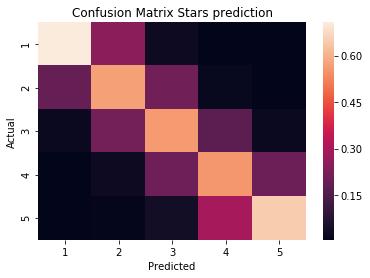

In [26]:
all_preds = np.array(all_preds)
print(all_preds.shape)
y_predictions = all_preds.argmax(axis=1)
y_true = y_test.argmax(axis=1)
y_true = y_true[:len(y_predictions)]

cm = ConfusionMatrix(y_true, y_predictions)
cm.plot(backend='seaborn', normalized=True)
plt.title('Confusion Matrix Stars prediction')
plt.figure(figsize=(12, 10))

test_correctPred = np.equal(y_predictions, y_true)
test_accuracy = np.mean(test_correctPred.astype(float))

print(test_accuracy)

# Test out the network yourself!
User can enter a review here and see how the network does in predicting his or her review

In [56]:
load_files = True
if load_files == True:
    word_embedding_matrix = loadfiles("./data/word_embedding_matrix.p")
    word2int = loadfiles('word2int.p')

pred_text = input("Please enter a review in english")
contractions = get_contractions()
pred_text = clean_text(pred_text, contractions)
pred_seq = convert_to_ints(pred_text, pred=True)
pred_seq = np.tile(pred_seq, (batch_size, 1))

with tf.Session(graph=train_graph) as sess:
    checkpoint = "./saves/best_model.ckpt"  
    all_preds = []
    with tf.Session() as sess:
        saver = tf.train.Saver()
        # Load the model
        saver.restore(sess, checkpoint)
        test_state = sess.run(graph.initial_state)
        feed = {graph.input_data: pred_seq,
                graph.keep_prob: keep_probability,
                graph.initial_state: state}

        predictions = sess.run(graph.predictions, feed_dict=feed)
        for i in range(len(predictions)):
            all_preds.append(predictions[i,:])
all_preds = np.array(all_preds)
y_predictions = all_preds.argmax(axis=1)
counts = np.bincount(y_predictions)
print("\nYou rated the restaurant: " + str(np.argmax(counts)) + " stars!")

Please enter a review in englishThis place was alright. Food was lackluster but the atmosphere was great! Service was decent
INFO:tensorflow:Restoring parameters from ./saves/best_model.ckpt

You rated the restaurant: 2 stars!
